In [63]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Importing sentiment data 
`sentiment_data` imported below is a dictionary whose keys are tickers for which sentiment analysis was done.

In [ ]:
with open('sentiment_data.pkl', 'rb') as f:
    sentiment_data = pickle.load(f)

In [1012]:
print(f"The keys are the tickers: {sentiment_data.keys()}\n{'='*115}\n")
print(f"Each value is a list of dictionaries, and each dictionary corresponds to a 10-Q filing having the following form:\n")
print('\t\t',sentiment_data['NWS'][0])

The keys are the tickers: dict_keys(['NWS', 'CDNS', 'WSM', 'HWM', 'CAT', 'LII', 'CME', 'PSX', 'WAB', 'MCD', 'INVH', 'HD', 'ELV', 'NDSN', 'LVS', 'AKAM', 'COR', 'XEL', 'SPG', 'VMC', 'CSX', 'PEG', 'VICI', 'ESS', 'PAYX', 'LDOS', 'COP', 'DVN', 'DAY', 'ETN', 'CSCO', 'RL', 'UNH', 'DOV', 'WRB'])

Each value is a list of dictionaries, and each dictionary corresponds to a 10-Q filing having the following form:

		 {'date': datetime.date(2024, 5, 9), 'positive': 51, 'negative': 45}


## Sentiment Dynamics Over Time

**Definition:** The *Optimism Index* of a sentiment analysis of a 10-Q filing is defined as the ratio of the number of positive sentences to the number of negative sentences, as determined by sentiment analysis.

The following scatter plots illustrate how the Optimism Index evolves over time for each ticker, providing a visual representation of sentiment dynamics across reporting periods.


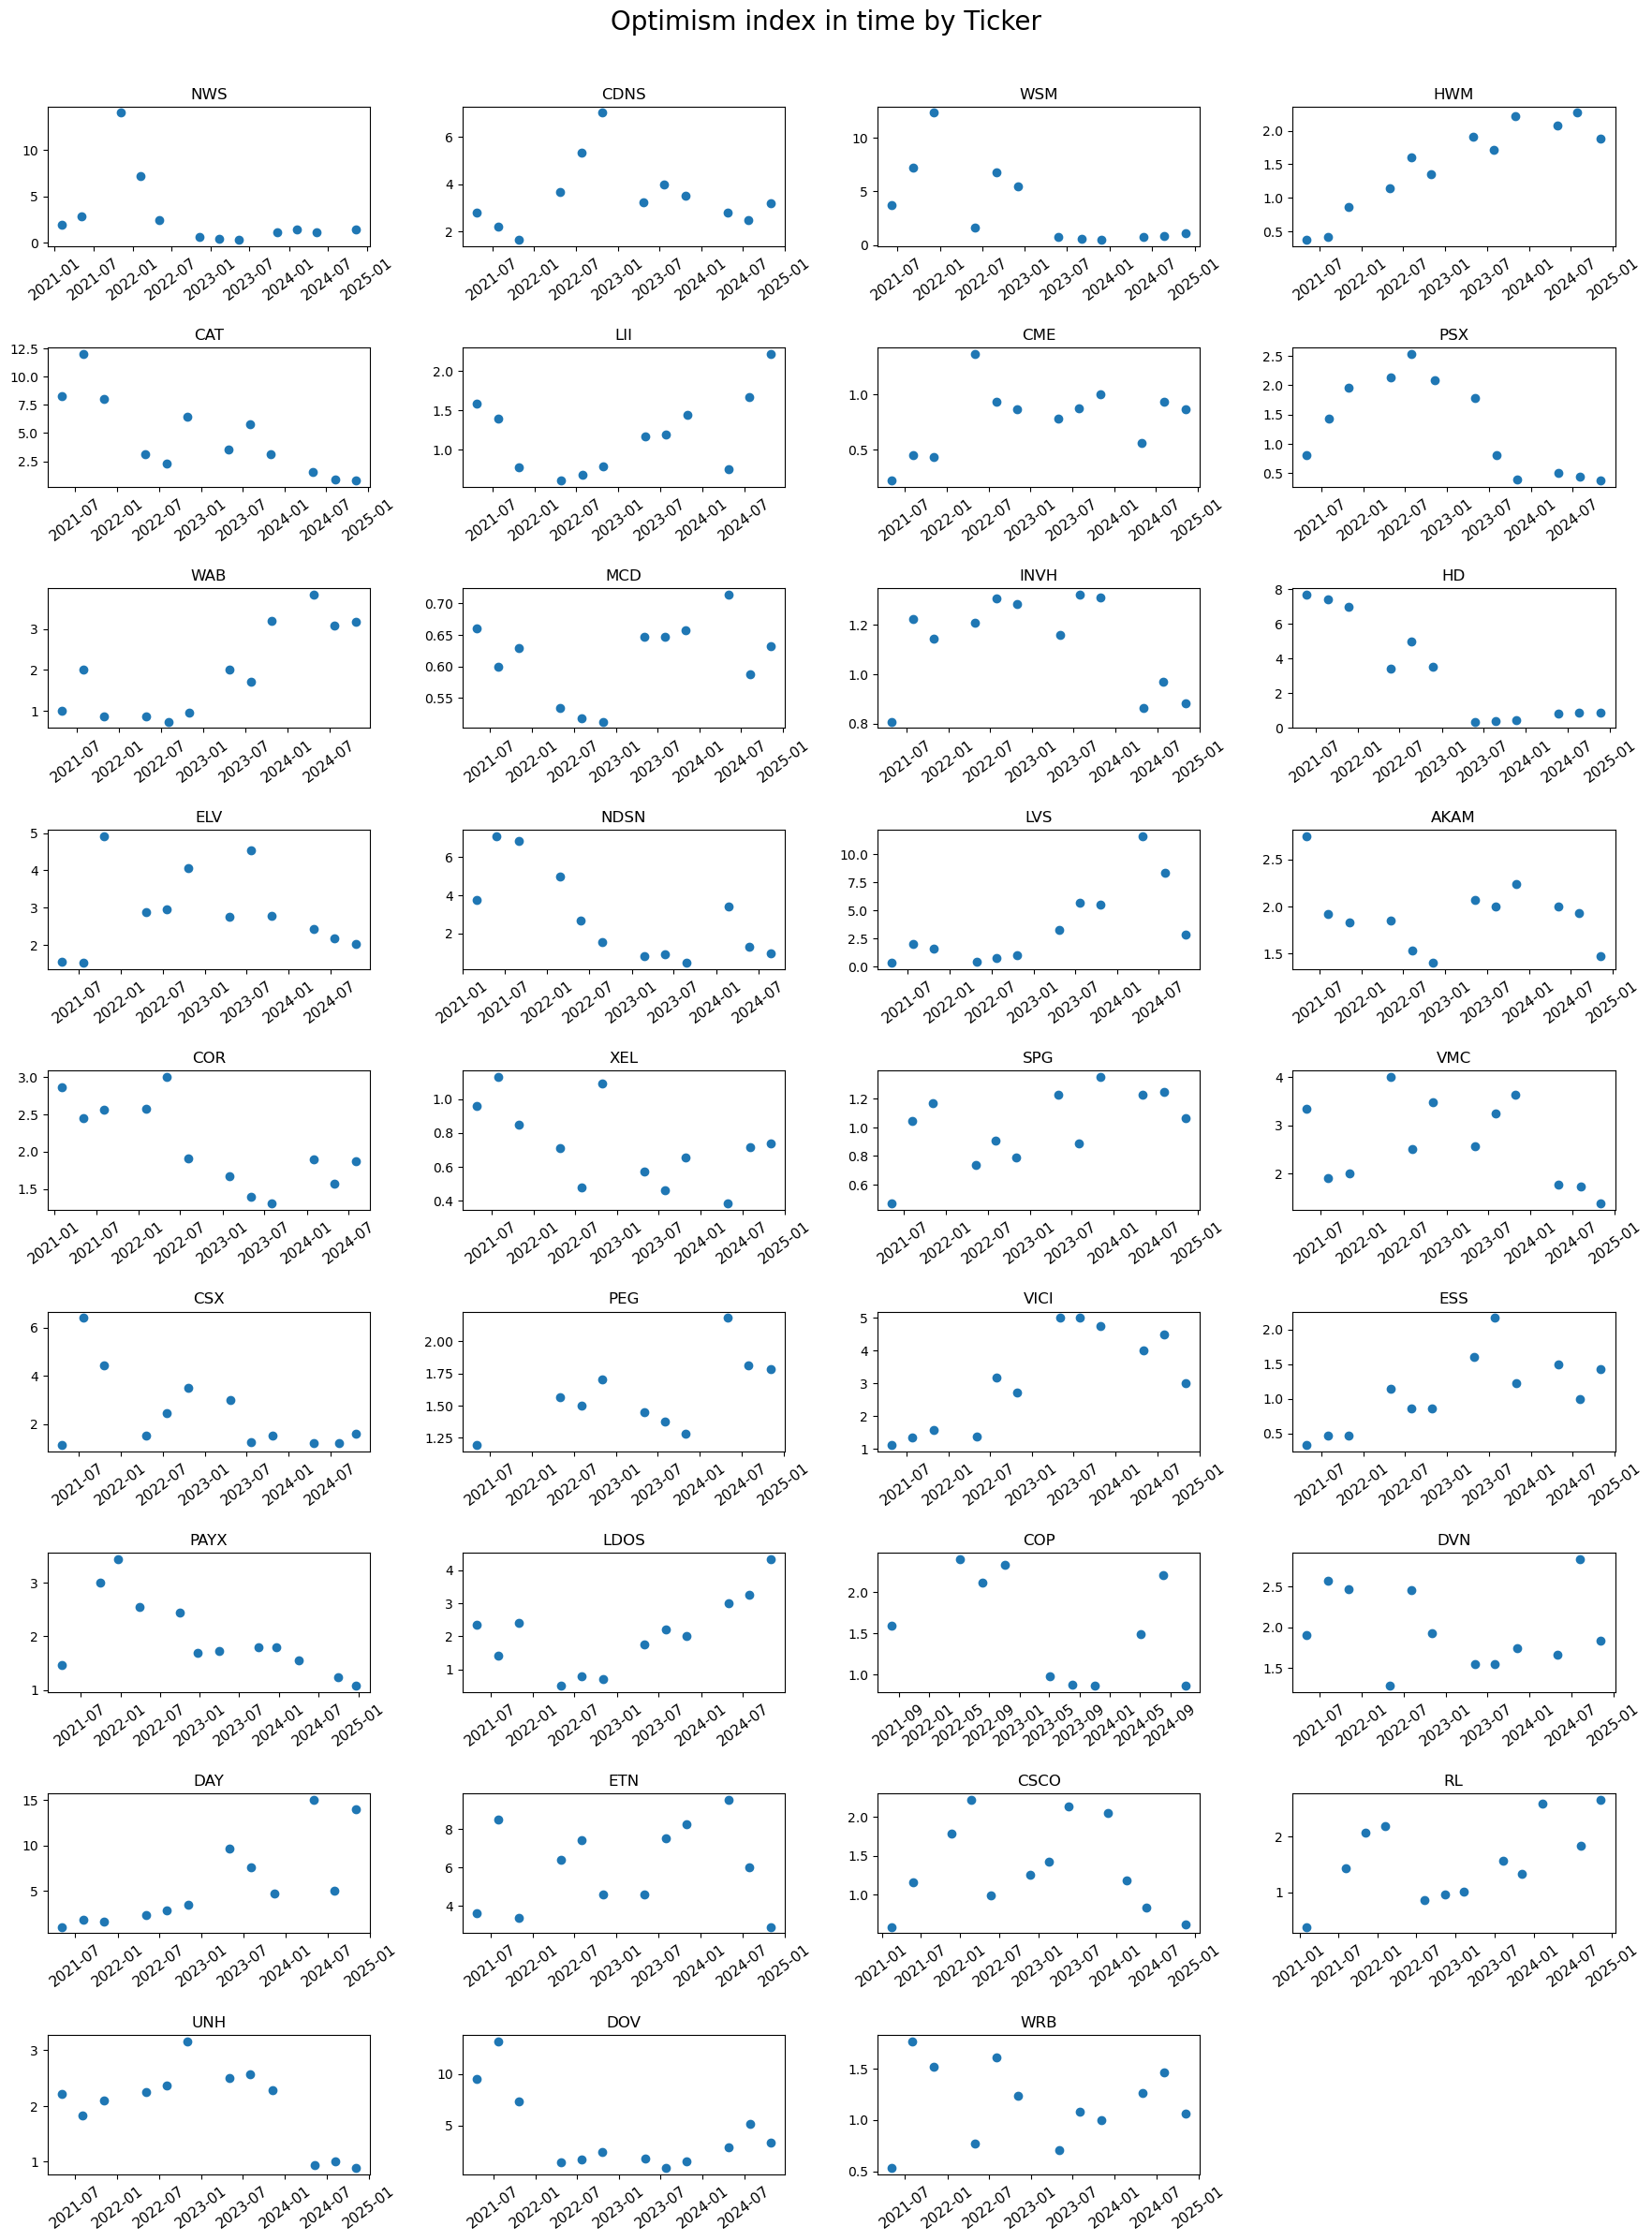

In [1070]:
fig , ax = plt.subplots(9,4,figsize=(18,24))
ax = ax.flatten()

for i , ticker in zip([i for i in range(len(sentiment_data))],sentiment_data.keys()):
    dates_sents = [[q['date'],q['positive']/q['negative']] for q in sentiment_data[ticker]]
    dates_sents.sort(key = lambda  x : x[0])
    dates = [x[0] for x in dates_sents]
    sents = [x[1] for x in dates_sents]
    ax[i].scatter(dates,sents)
    ax[i].set_title(ticker)
    ax[i].tick_params(axis='x',rotation=37,labelsize=11)
    
fig.delaxes(ax[35])
fig.suptitle('Optimism index in time by Ticker', fontsize=20,y=1)
plt.tight_layout(pad=2)
#plt.savefig('Optimism index in time')

## Importing Ticker Stock Price Data

We download stock price data using the Yahoo Finance API (via `yfinance`) as follows:

- For each ticker, we retrieve approximately 85 consecutive closing prices **before** the 10-Q filing date (excluding the filing date), and approximately 85 consecutive closing prices **after** the filing date (including the filing date).
- The reason we obtain fewer than 100 prices (e.g., only ~85) is due to non-trading days such as weekends and market holidays.

All relevant data — including sentiment analysis results and associated stock prices — is collected in a DataFrame named `sent_df`.


In [ ]:
import yfinance as yf
from datetime import datetime , timedelta
import time
from tqdm.notebook import tqdm
import copy
sentiment_data_and_prcs=copy.deepcopy(sentiment_data)
k=100

#I tried to download 100 close prices preceding the filing date and 100 close prices after filing date. However,
#only ~85 prices were downloaded before/after filing date due to various market closures.
for ticker in tqdm(sentiment_data.keys(),desc='Ticker processed'):
    for i in range(len(sentiment_data[ticker])):
        filing_date = datetime.combine(sentiment_data_and_prcs[ticker][i]['date'], datetime.min.time())
        buffer=30 #to acount for days of the week which aren't trading days
        before_date = filing_date - timedelta(k+buffer)
        after_date = filing_date + timedelta(k+buffer)
        df = yf.download(ticker, start = before_date, end = after_date)
        time.sleep(0.5)
        sentiment_data_and_prcs[ticker][i]['start prices list']= df[df.index < filing_date]['Close'].tail(k)
        sentiment_data_and_prcs[ticker][i]['end prices list'] = df[df.index >= filing_date]['Close'].head(k)
        
#Creating sent_df

rows = []
for ticker , filing_list in sentiment_data_and_prcs.items():
    for file in filing_list:
        row = {'ticker' : ticker}
        row.update(file)
        rows.append(row)
sent_df = pd.DataFrame(rows)
#start/end price list are accidentally DataFrames, and the following transofrms them to Series
sent_df['start prices list'] = sent_df['start prices list'].map(lambda x: x.iloc[:,0])
sent_df['end prices list'] = sent_df['end prices list'].map(lambda x: x.iloc[:,0])
#computing positive/negative sentiments
sent_df['sent ratio'] = sent_df['positive'] / sent_df['negative'] 
import pickle
with open('sent_df.pkl', 'wb') as f:
    pickle.dump(sent_df, f)

In [1013]:
sent_df.head()

,ticker,date,positive,negative,start prices list,end prices list,sent ratio
0,NWS,2024-05-09,51,45,Date 2024-01-02 25.341028 2024-01-03 25....,Date 2024-05-09 25.453678 2024-05-10 25....,1.133333
1,NWS,2023-11-09,26,23,Date 2023-07-03 19.472048 2023-07-05 19....,Date 2023-11-09 21.887682 2023-11-10 21....,1.130435
2,NWS,2021-05-07,63,22,Date 2020-12-28 17.371387 2020-12-29 17....,Date 2021-05-07 24.461151 2021-05-10 24....,2.863636
3,NWS,2021-11-05,42,3,Date 2021-06-28 23.313784 2021-06-29 23....,Date 2021-11-05 23.500578 2021-11-08 23....,14.000000
4,NWS,2023-02-10,29,71,Date 2022-10-03 15.561004 2022-10-04 16....,Date 2023-02-10 18.408962 2023-02-13 18....,0.408451


# Sentiment - price dynamics 

In this section, we analyze how the normalized sentiment ratio in 10-Q filings relates to short-term stock return behavior after the filing date. The analysis proceeds as follows:

- For each ticker, we loop through a range of rolling windows across post-filing stock prices to compute **return effects** relative to pre-filing prices.
- For each window position, we calculate an **effect metric** -- post-filing average price divided by pre-filing average price.
- We normalize both the sentiment ratio and the effect metric using standard scaling.
- We run a linear regression of normalized sentiment on normalized return effect using `statsmodels`' formula API.
- The slope coefficient from each regression represents the **sensitivity of sentiment to price effect** for that window position.
- We collect and visualize these slope coefficients over time to examine the dynamic relationship between sentiment and stock price reactions.

The final result is a panel of scatter plots (one per ticker) showing how this sensitivity evolves across different post-filing windows.

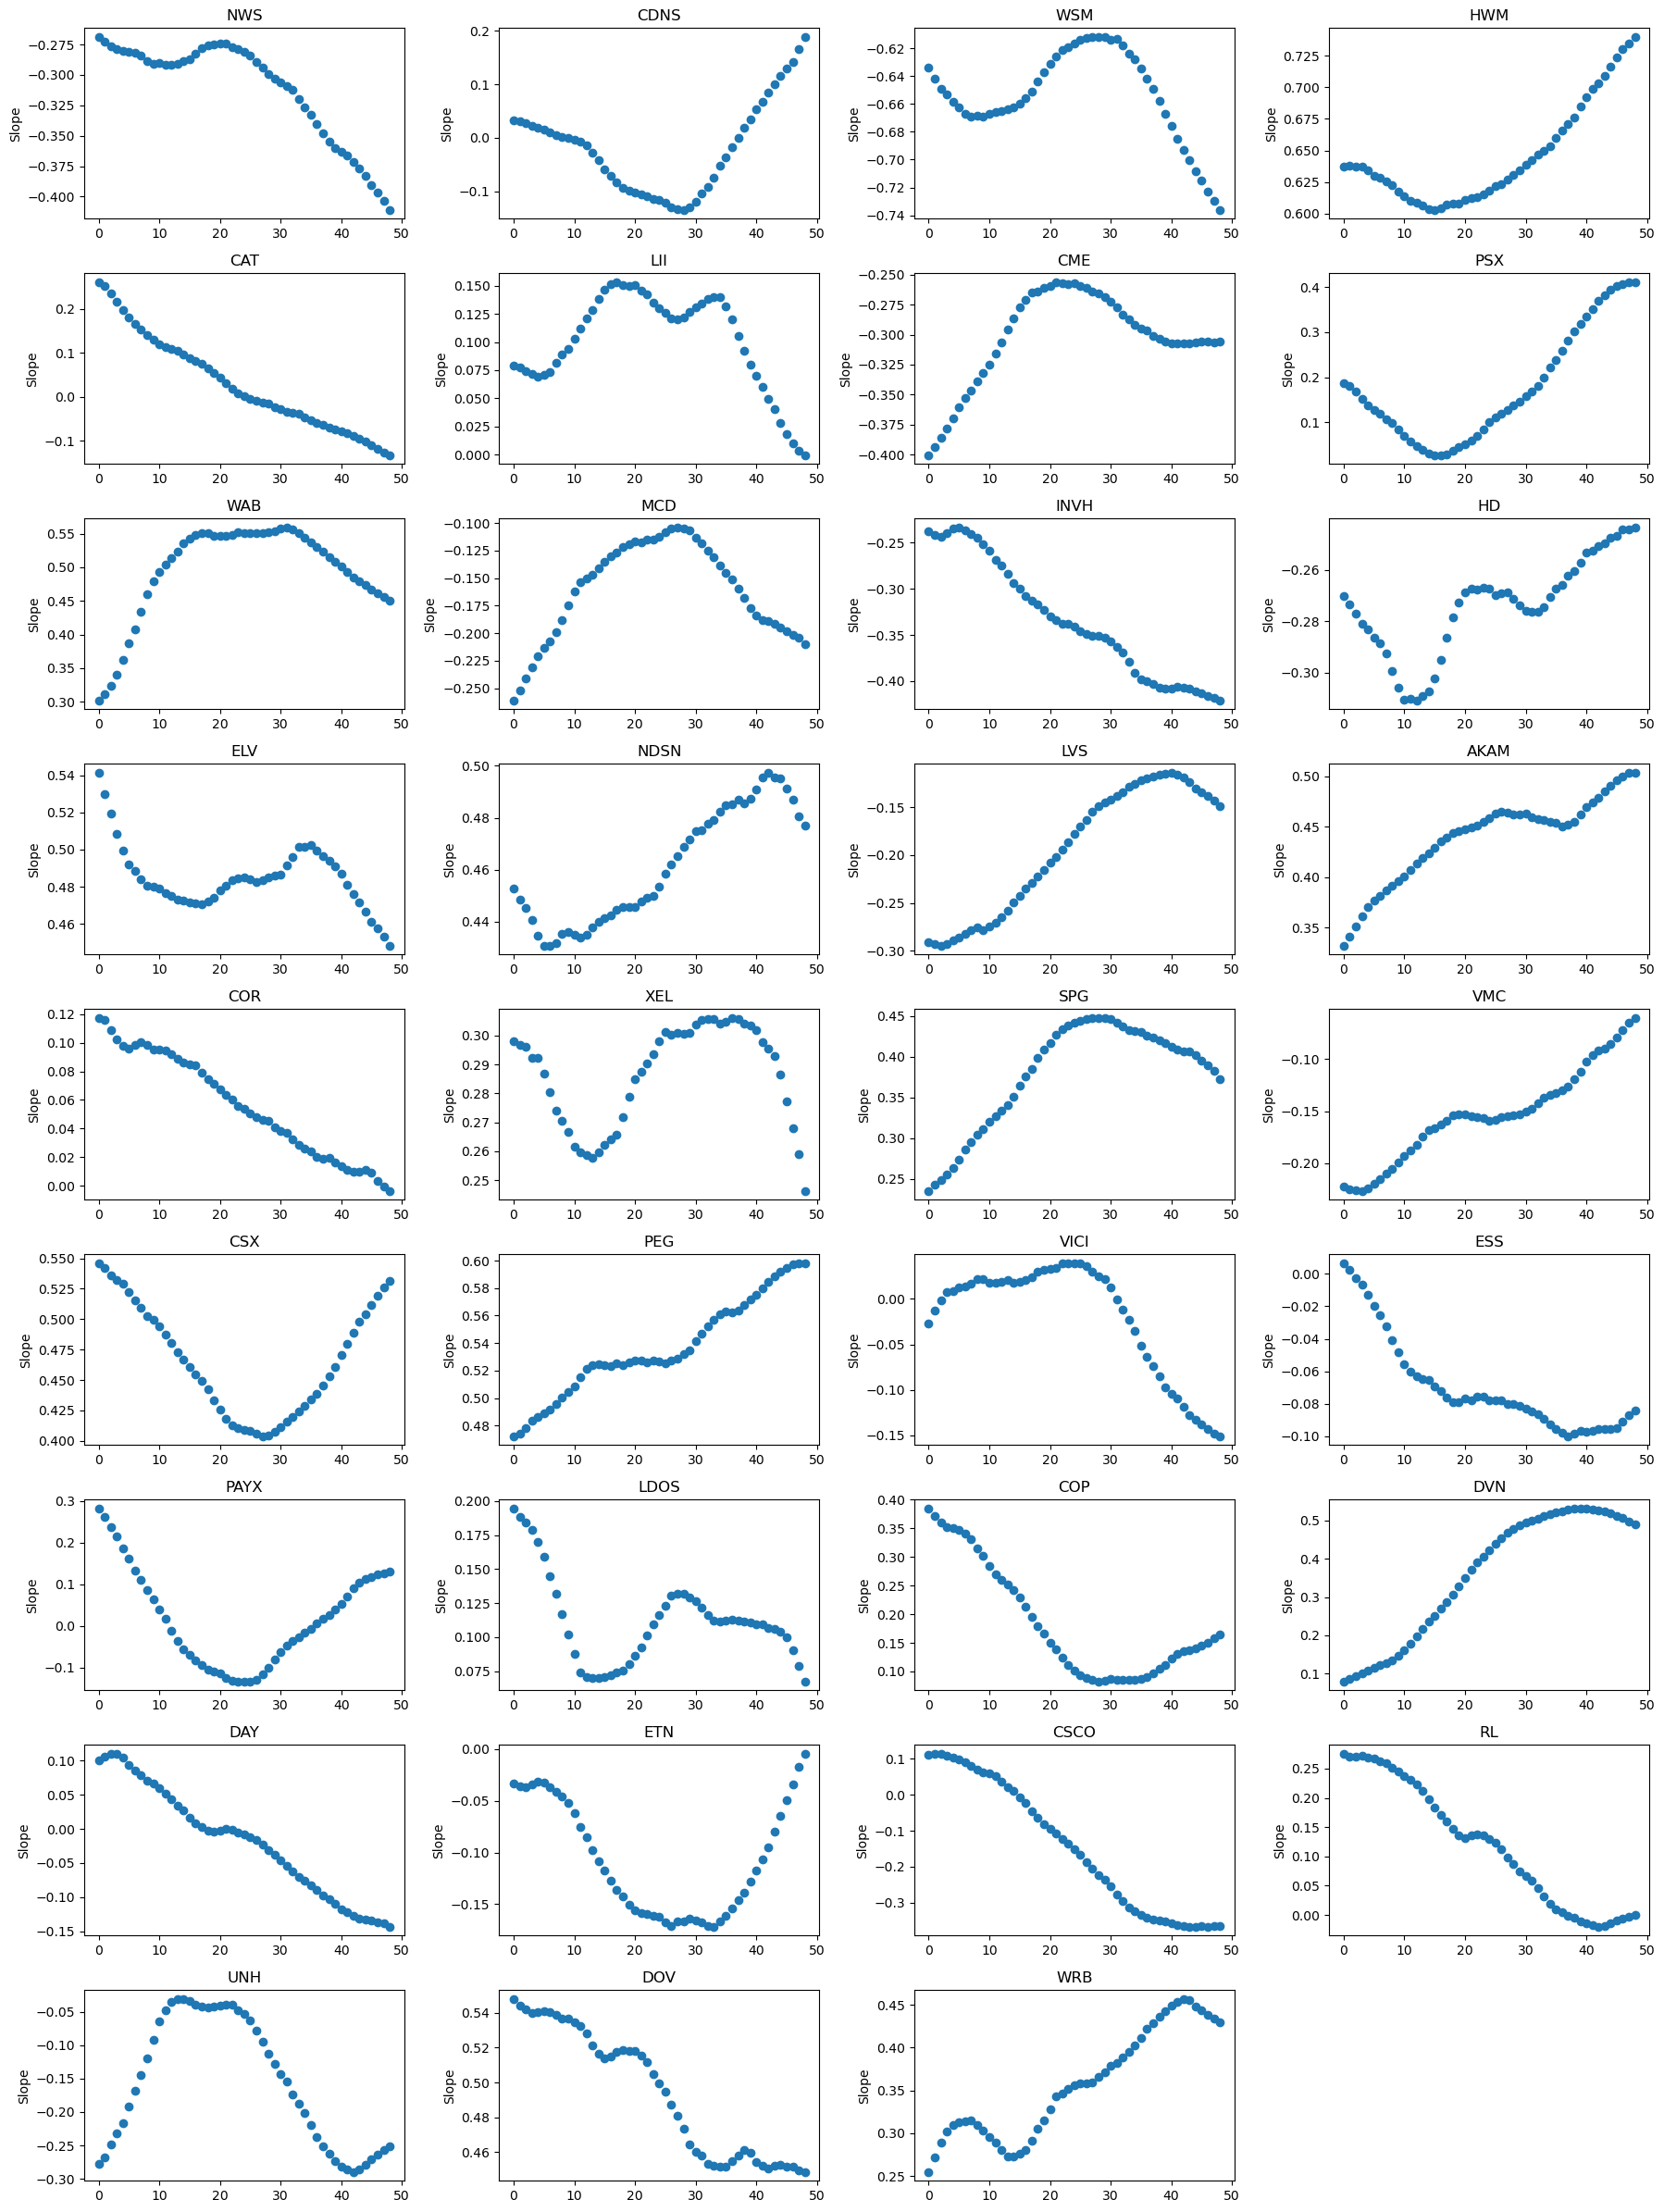

In [1017]:
import statsmodels.formula.api as smf
fig , ax = plt.subplots(9,4,figsize=(18,24))
ax = ax.flatten()
tickers=sent_df['ticker'].unique()

rng=[i for i in range(len(tickers))]
sent_dyn_df = pd.DataFrame(columns=['ticker', 'slopes_pattern'])
for i,ticker in zip(rng,tickers):
    
    analysis_df = sent_df[sent_df['ticker']==ticker].copy(deep=True)
    slopes = []
    #optional:
    #pvals = []
    #RSquares = []
    
    L=80-30
    time = [i for i in range(L-1)]
    for st in range(1,L):
        #prefiling price window (fixed): starting day before filing, and averging on a window of  20 days prior to that.
        k1 , a1 = 20 , 1
        #postfiling varying price windows: starting at day `st` after filing date and averging on a window of 
        #30 days starting at `st`.
        k2 , a2 = 30 , st 
        analysis_df['effect'] = analysis_df['end prices list'].apply(lambda x: x.iloc[a2:a2+k2].mean())/analysis_df['start prices list'].apply(lambda x: x.iloc[-a1-k1:-a1].mean())
        #applying standard scaling
        effects.append(analysis_df['effect'].mean())
        analysis_df['sent ratio normalized'] = analysis_df['sent ratio'].transform(lambda x: (x-x.mean())/x.std())
        analysis_df['effect_normalized'] = analysis_df['effect'].transform(lambda x: (x-x.mean())/x.std())
        # Run regression
        model = smf.ols("Q('sent ratio normalized') ~ effect_normalized", data=analysis_df).fit()
        slopes.append(model.params['effect_normalized'])
        #pvals.append(model.pvalues['effect_normalized'])
        #RSquares.append(model.rsquared)
        
    new_row = {'ticker':ticker,'slopes_pattern':slopes, 'effects':effects}
    sent_dyn_df = pd.concat([sent_dyn_df,pd.DataFrame([new_row])],ignore_index=True)    
    ax[i].scatter(time,slopes)
    ax[i].set_ylabel('Slope')
    ax[i].set_title(ticker)
    
    
fig.delaxes(ax[35])
plt.tight_layout()

    

### Randomization Check: Validating the Significance of Observed Patterns

To ensure that the observed patterns in the scatter plots are not artifacts, we perform a permutation test. Specifically, we randomly permute the normalized optimism index values (`sent ratio normalized`) for each ticker and rerun the analysis. This helps determine whether the relationship between sentiment and post-filing return effects is statistically meaningful or could arise by chance.


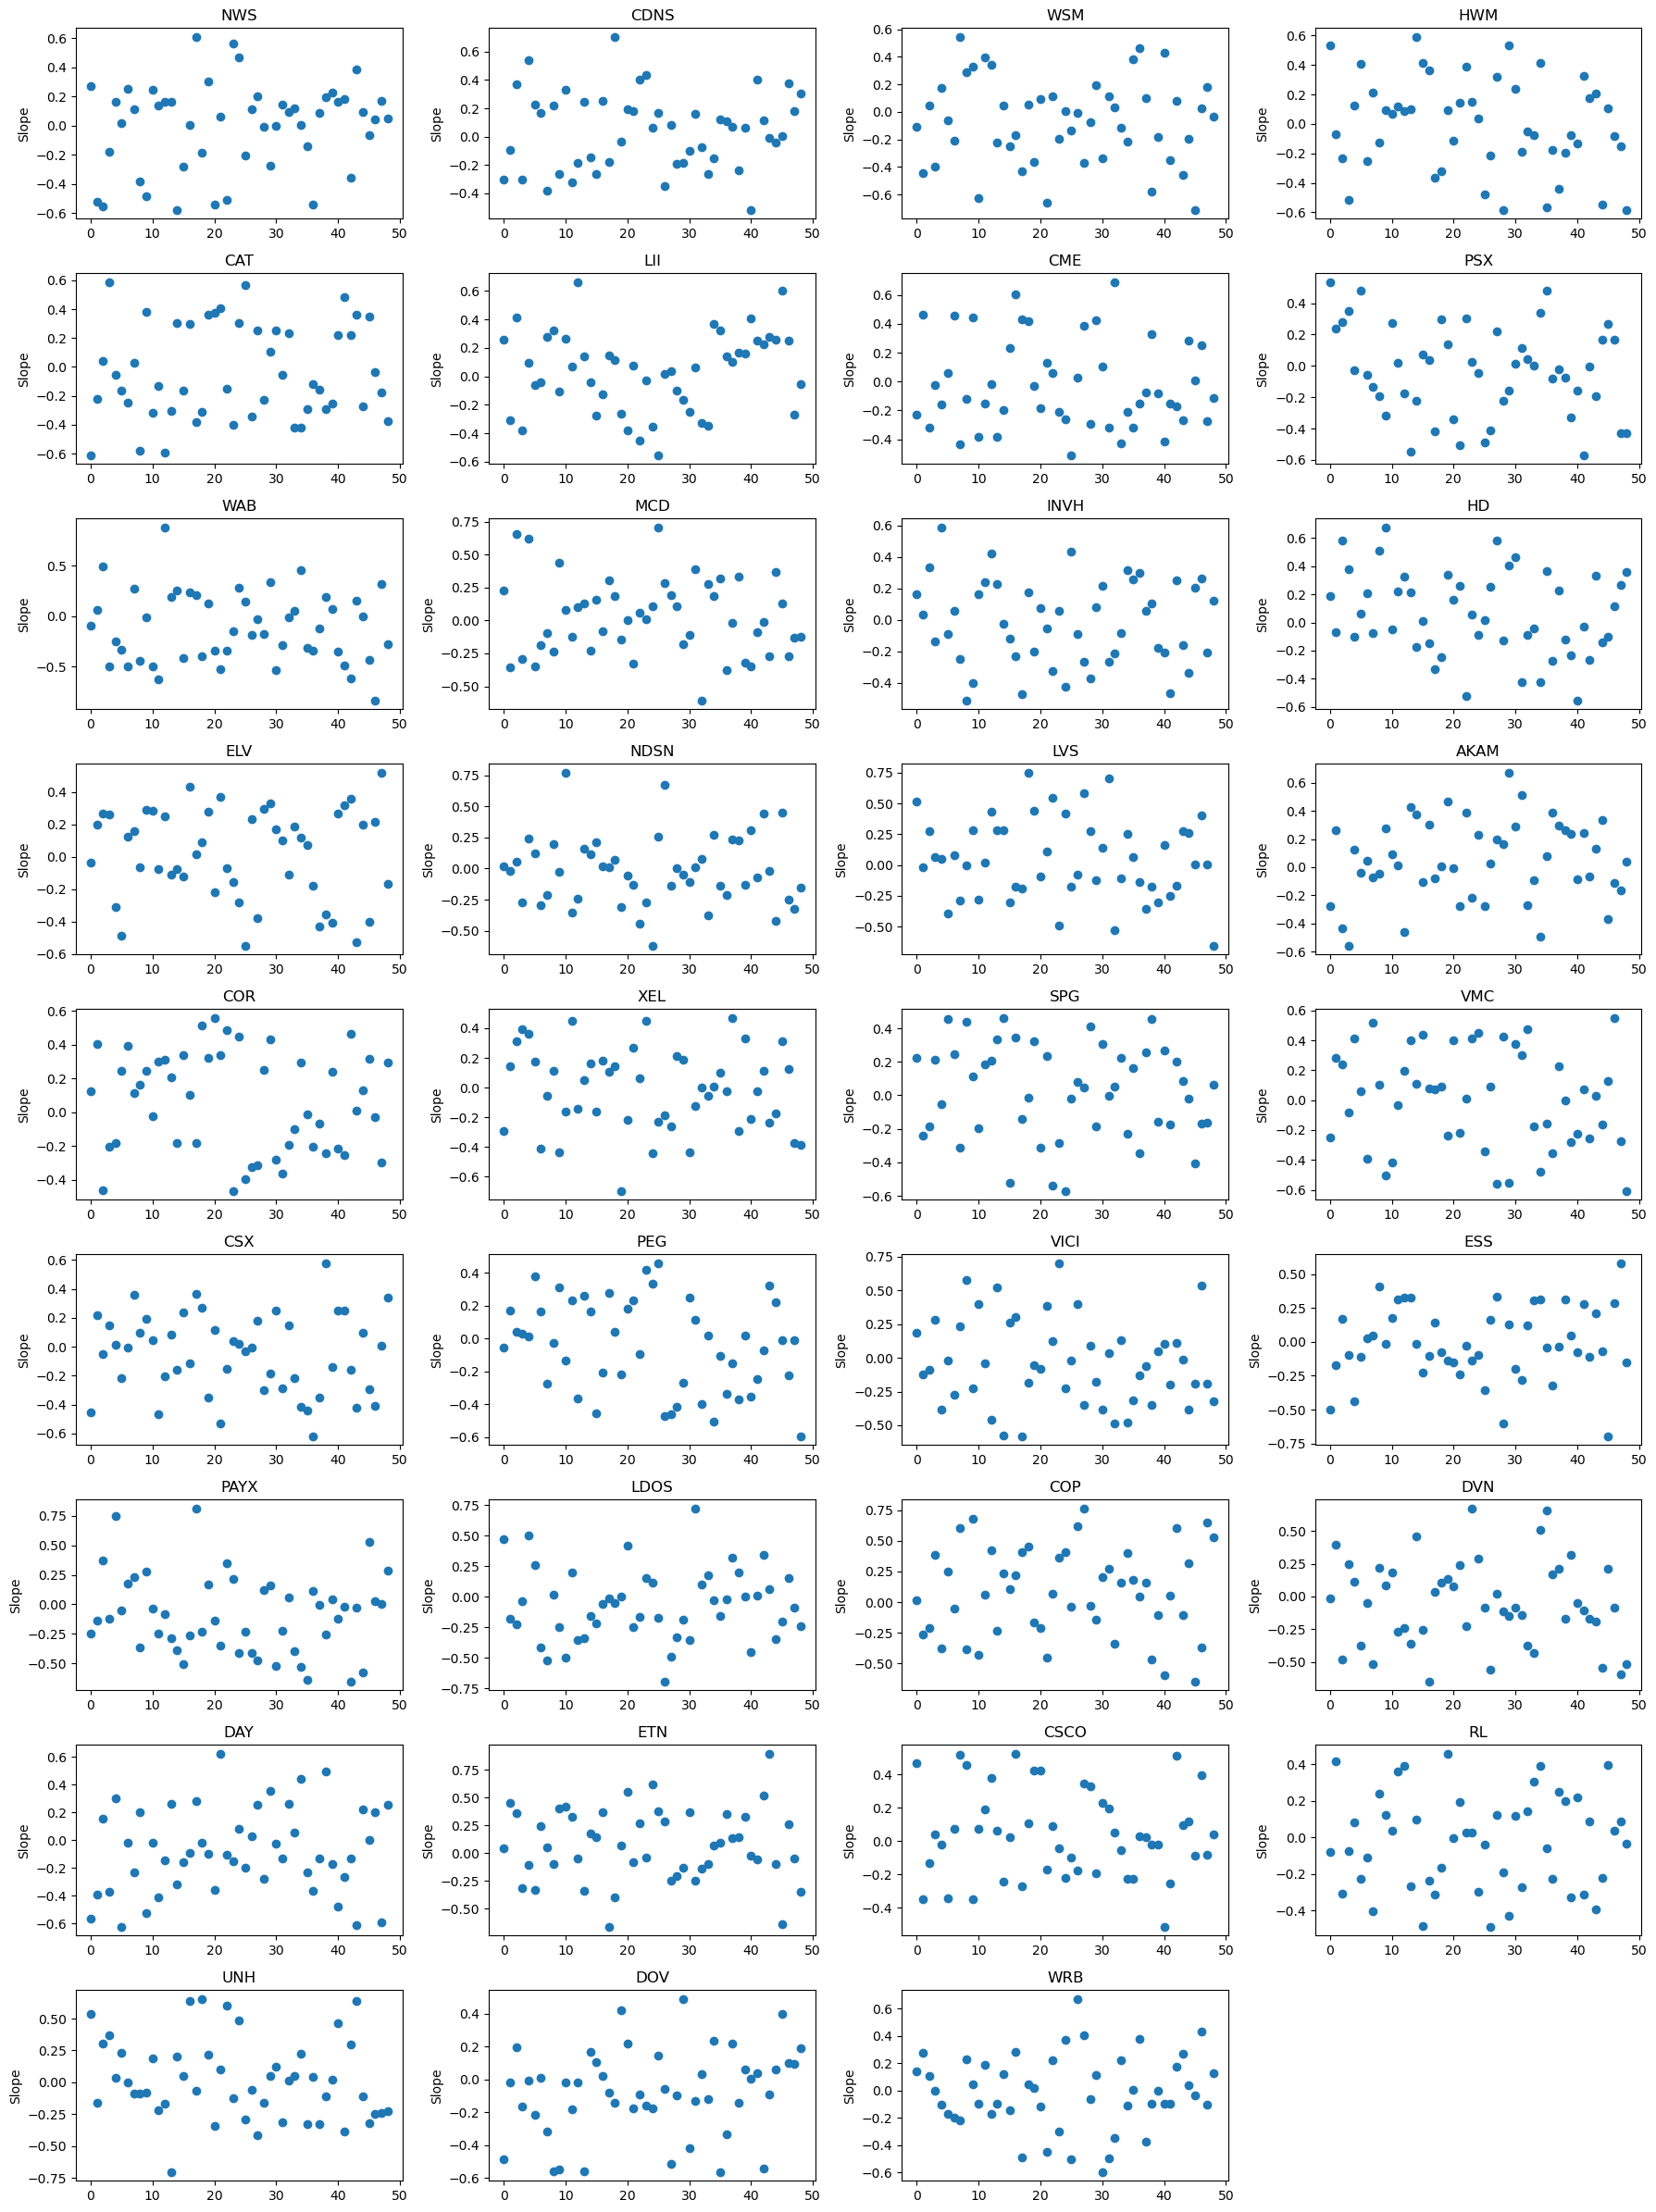

In [1018]:
import random

fig , ax = plt.subplots(9,4,figsize=(18,24))
ax = ax.flatten()
tickers=sent_df['ticker'].unique()

rng=[i for i in range(len(tickers))]

for i,ticker in zip(rng,tickers):
    
    analysis_df_permute_opt = sent_df[sent_df['ticker']==ticker].copy(deep=True)
    slopes = []
    
    
    L=80-30
    time = [i for i in range(L-1)]
    for st in range(1,L):
        k1 , a1 = 20 , 1
        k2 , a2 = 30 , st 
        analysis_df_permute_opt['effect'] = analysis_df_permute_opt['end prices list'].apply(lambda x: x.iloc[a2:a2+k2].mean())/analysis_df_permute_opt['start prices list'].apply(lambda x: x.iloc[-a1-k1:-a1].mean())
        #applying standard scaling
        effects.append(analysis_df_permute_opt['effect'].mean())
        analysis_df_permute_opt['sent ratio normalized'] = analysis_df_permute_opt['sent ratio'].transform(lambda x: (x-x.mean())/x.std())
        #Permuting optimism index
        analysis_df_permute_opt['sent ratio normalized'] = np.random.permutation(analysis_df_permute_opt['sent ratio normalized'])
        
        analysis_df_permute_opt['effect_normalized'] = analysis_df_permute_opt['effect'].transform(lambda x: (x-x.mean())/x.std())
        # Run regression
        model = smf.ols("Q('sent ratio normalized') ~ effect_normalized", data=analysis_df_permute_opt).fit()
        slopes.append(model.params['effect_normalized'])
       
        
       
    #ax[i].scatter(time,effects)
    ax[i].scatter(time,slopes)
    #ax[i].set_ylabel('Effect average')
    ax[i].set_ylabel('Slope')
    ax[i].set_title(ticker)
    
    
fig.delaxes(ax[35])
plt.tight_layout()

    

After permuting the normalized optimism index for each ticker, the scatter plots no longer exhibit structured patterns. Instead, they appear random, indicating that the original relationships between sentiment and post-filing return effects are not likely to be artifacts of the data structure. This supports the conclusion that the observed patterns in the original analysis reflect meaningful associations.

## Sentiment–Price Effect Dynamics Classification

The slope variation plots above are now grouped into clusters of similar shapes. To achieve this, we apply **KMeans clustering** to:

1. The standardized evolution of slope values over time, and  
2. The standardized **first derivative** (i.e., rate of change) of those slope values.

This allows us to classify tickers based on the dynamic relationship between sentiment and price effects, capturing not just the level but also the trend and variability of the sentiment–return sensitivity over time.


In [1067]:
X = np.array(sent_dyn_df['slopes_pattern'].tolist())

X_norm = (X-X.mean(axis=1,keepdims=True) )/X.std(axis=1,keepdims=True)                  
# First derivative (slope of slope)
dX = np.diff(X_norm, axis=1)  

# Second derivative (curvature), optional
#ddX = np.diff(dX, axis=1)     

# Combine standardized slope patterns, their derivatives, and the mean slope

X_joint = np.concatenate([X[:, :-1], X_norm, dX], axis=1)
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
X_reduced = pca.fit_transform(X_joint)

In [1068]:
from sklearn.cluster import KMeans
C=10
model = KMeans(C,random_state=11, n_init=100)
#sent_dyn_df['cluster'] = model.fit_predict(X_joint)
sent_dyn_df['cluster'] = model.fit_predict(X_reduced)

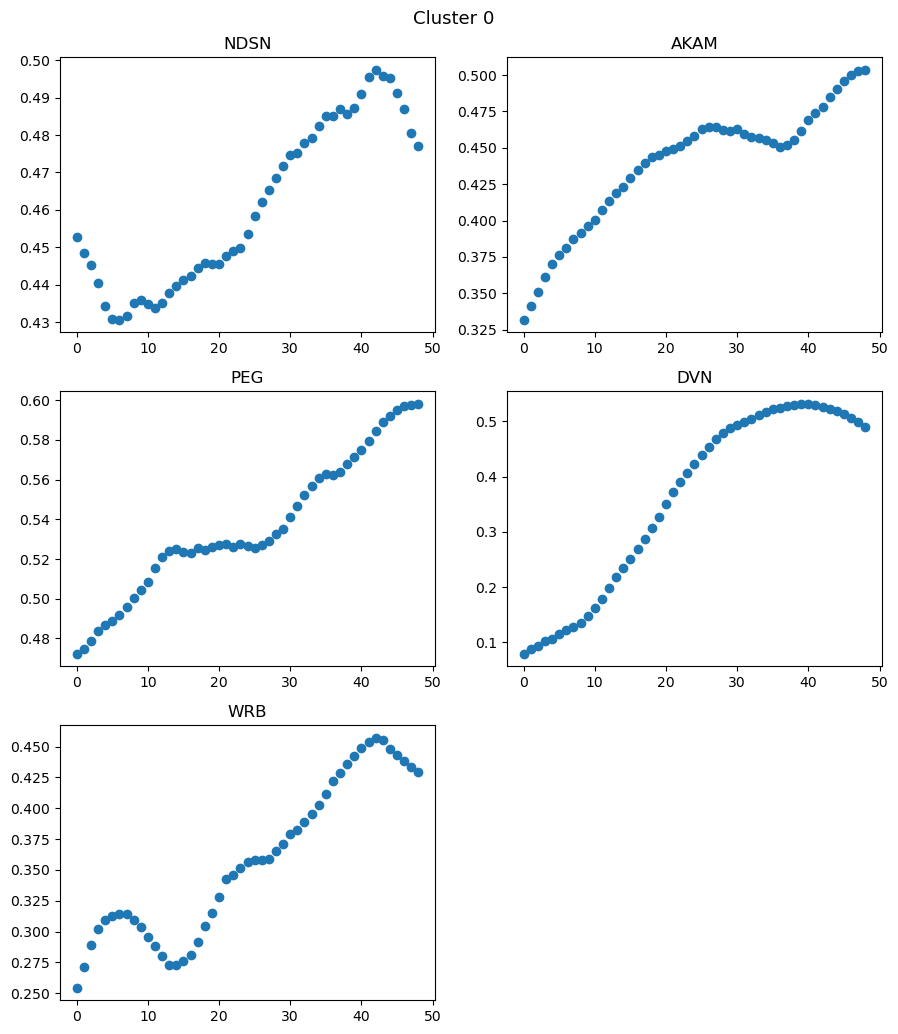

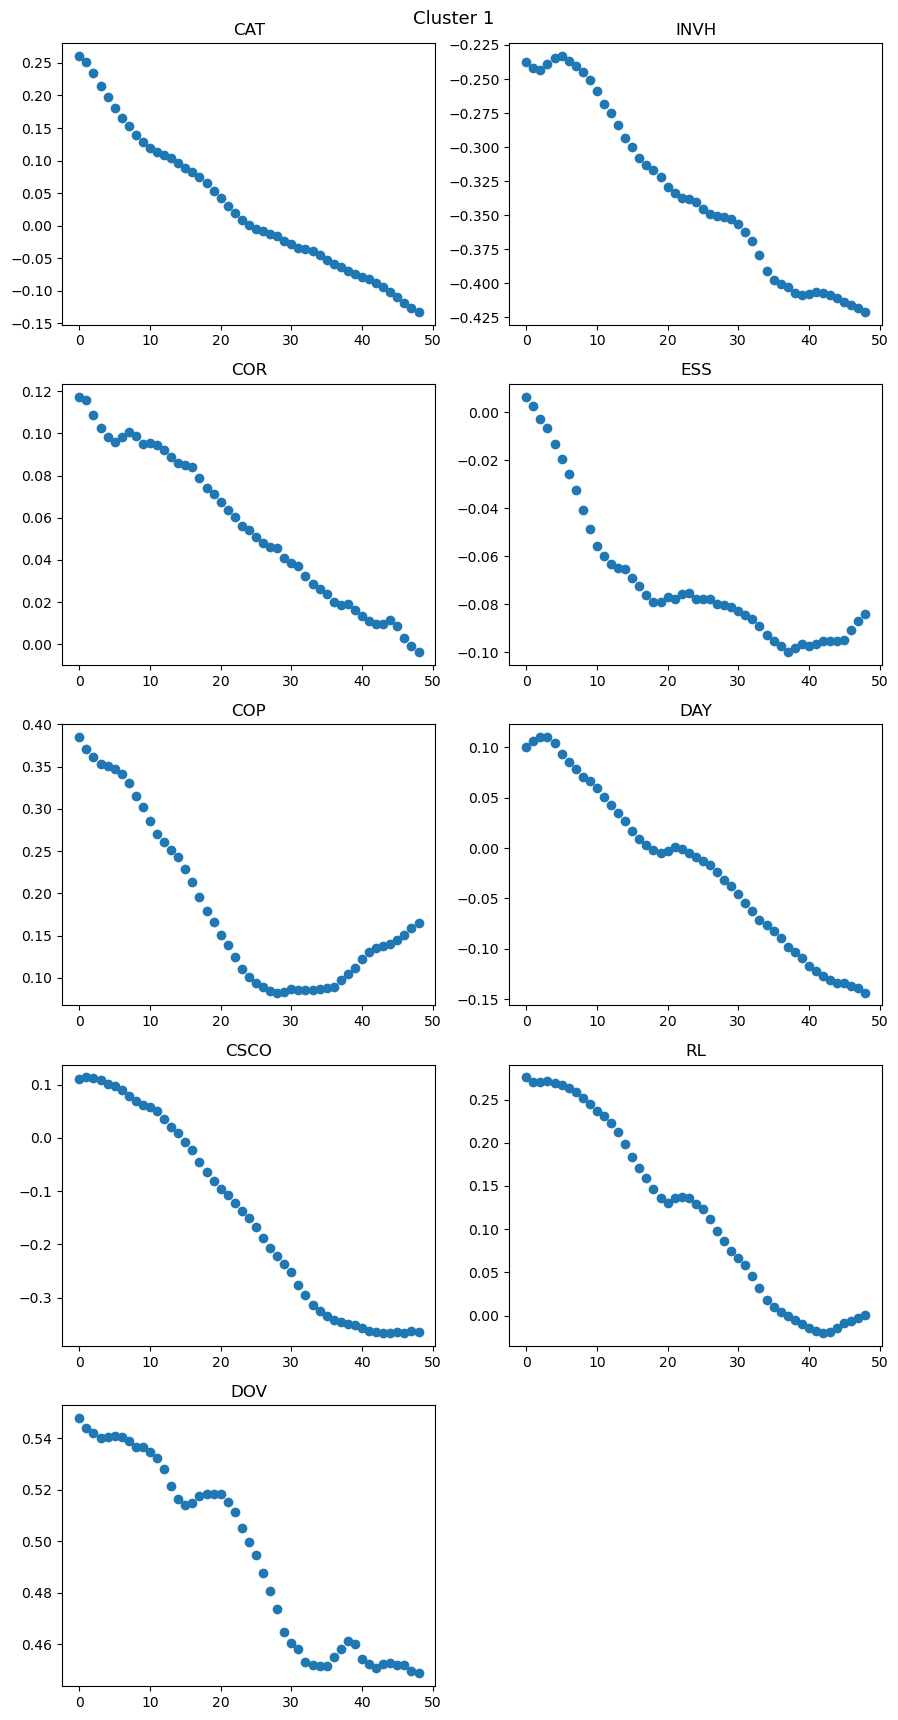

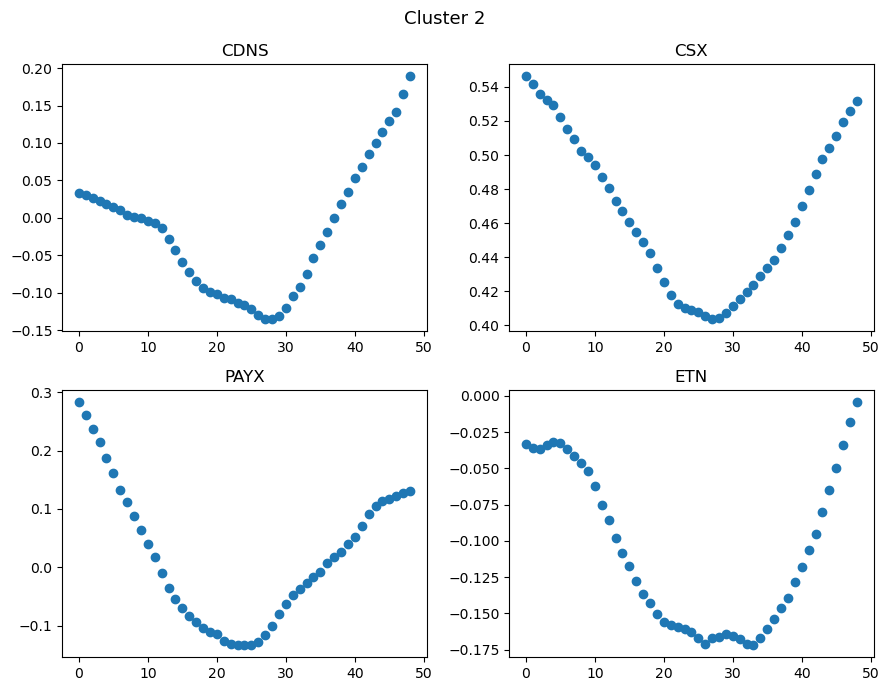

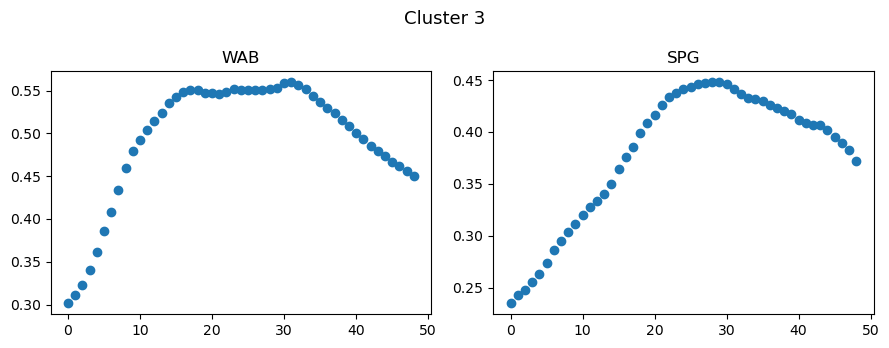

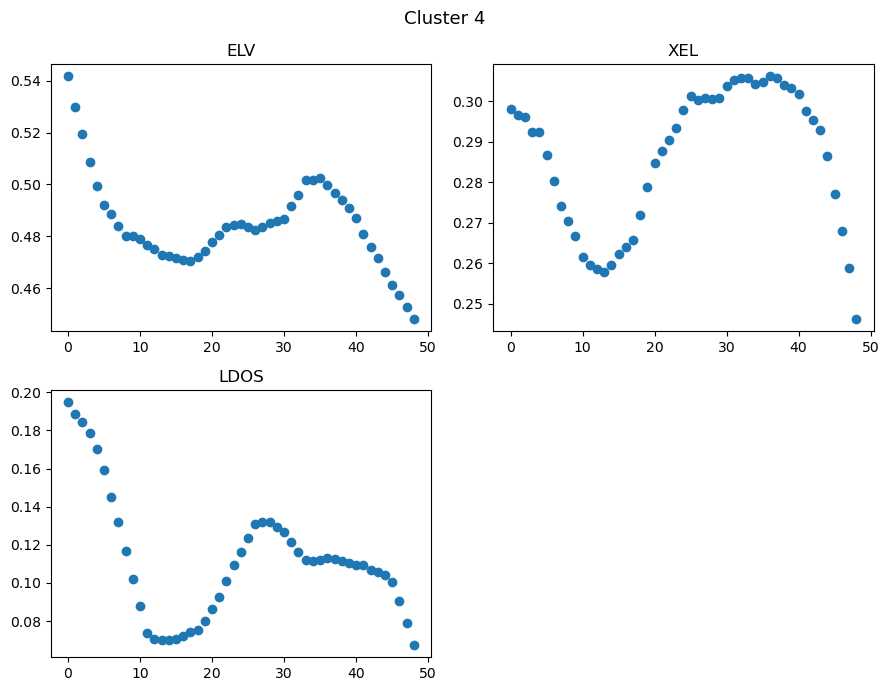

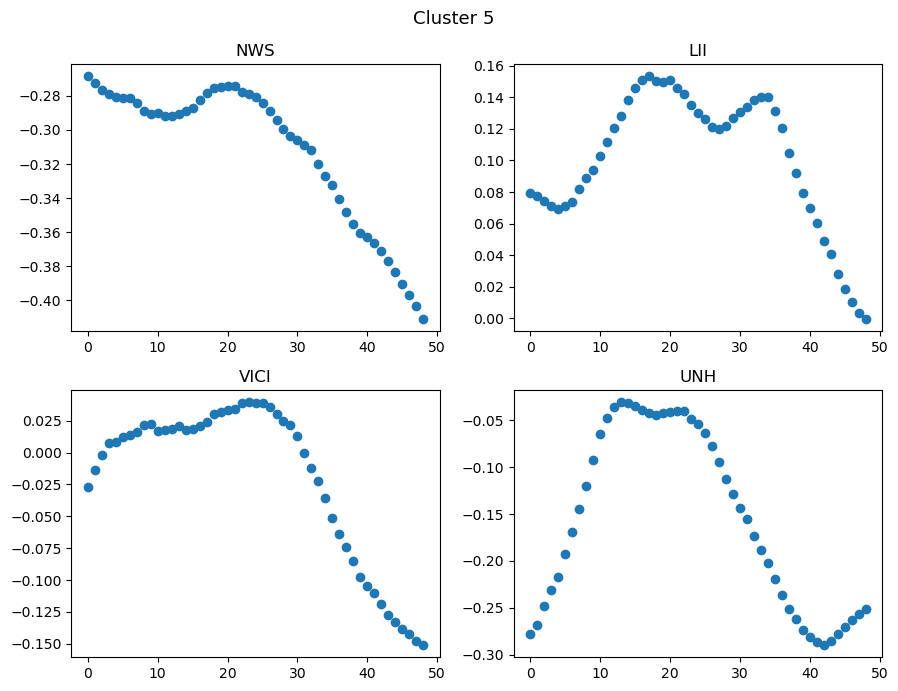

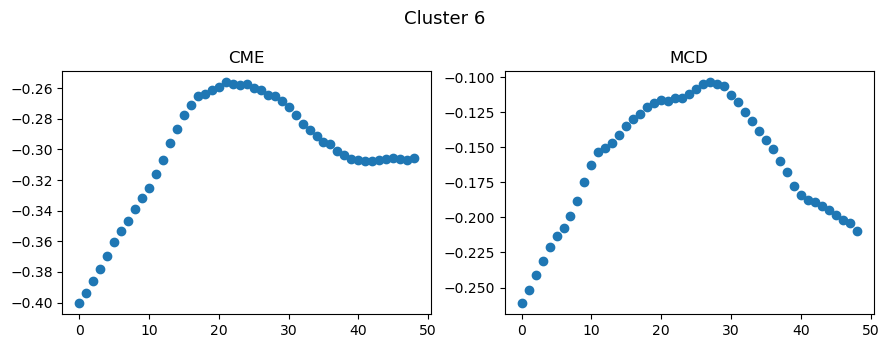

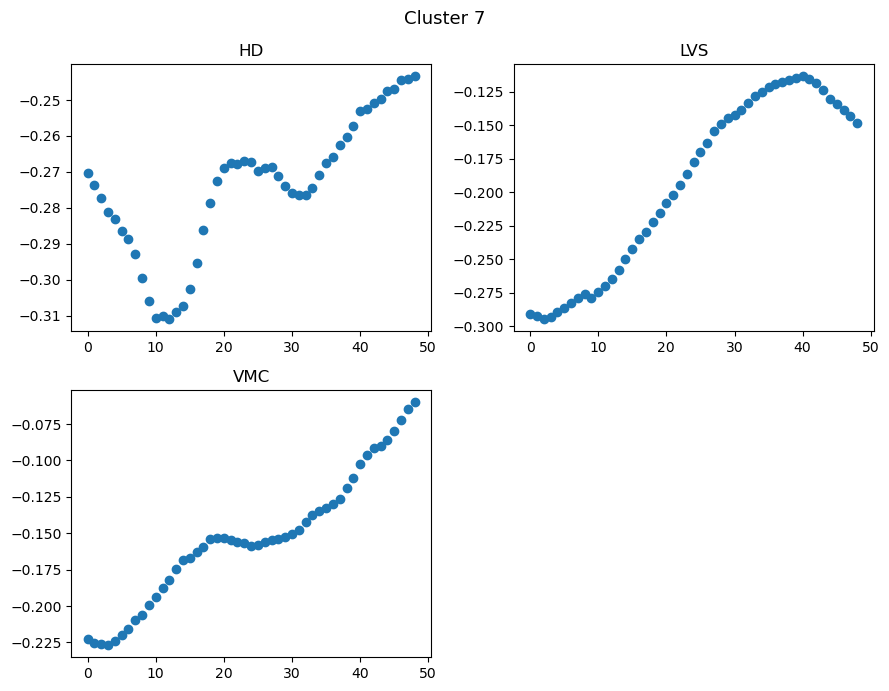

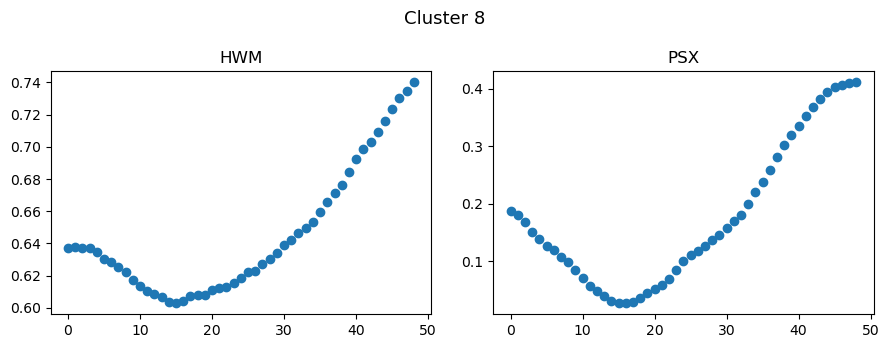

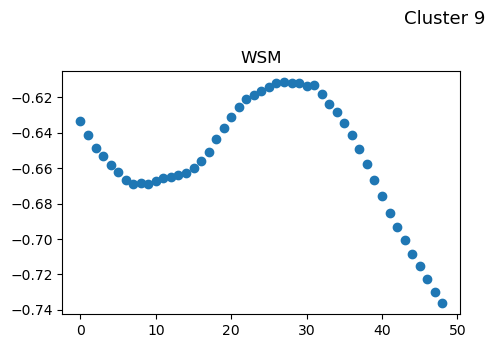

In [1069]:
import math
cols = 2
for c in range(C):
    cluster_df = sent_dyn_df[sent_dyn_df['cluster'] == c].copy()
    tickers = cluster_df['ticker'].tolist()
    k = len(tickers)
    rows = math.ceil(k / cols)

    fig, ax = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 3.5))
    ax = ax.flatten()

    for i, ticker in enumerate(tickers):
        # plot your pattern here
        
        ax[i].scatter(time,cluster_df[cluster_df['ticker']==ticker]['slopes_pattern'].iloc[0])
        ax[i].set_title(ticker)

    # Remove unused axes
    for j in range(i+1, len(ax)):
        fig.delaxes(ax[j])

    fig.suptitle(f"Cluster {c}", fontsize=13)
    plt.tight_layout()
    plt.savefig(f'Cluster {c}.jpg')    


## Summary: Sentiment–Return Dynamics Clustering

In this project, I analyzed the relationship between 10-Q filing sentiment and post-filing stock price behavior by studying the time-evolution of regression slopes. Using standardized slope trajectories and their derivatives, I applied KMeans clustering to identify patterns across firms.

### Key Findings:
1. **Distinct shape-based clusters** emerged, revealing different dynamic patterns in how sentiment affects returns over time (e.g., early spikes, delayed effects, U-shaped responses).
2. However, the **absolute magnitude and direction of the slopes** (i.e., whether sentiment had a positive or negative impact) were not well-separated by the clustering. This is a natural limitation when clustering on standardized shape alone.

### Future Work:
- **Expand the dataset** to include more tickers and more filing dates per firm.
- Train a **neural network model (e.g., 1D CNN or autoencoder)** to detect and classify slope dynamics. With sufficient data, this would enable pattern recognition that accounts for both shape and value, potentially improving interpretability and predictive power.
